# Mood-Based Music Recommender (Scientific Computing Project)

This notebook demonstrates an end-to-end **mood-based song recommender** built on the Spotify tracks dataset.

We will:
1. Load and preprocess the data
2. Engineer a simple **rule-based mood model** using `valence` and `energy`
3. Apply **PCA** to build a low-dimensional "mood space" (linear algebra)
4. Build **alternative mood models**:
   - K-means clustering on PCA space
   - Gaussian Mixture Model (GMM) on PCA space
5. Compare mood models using clustering metrics and visualizations
6. Implement a simple **song recommender** that, given a mood, returns the nearest songs

You can run this notebook cell by cell to demonstrate that the code works.

## 1. Setup and Data Loading

In [76]:


import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

import matplotlib.pyplot as plt


DATA_PATH = "dataset.csv"  
df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
df.head()


Shape: (114000, 21)


,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [77]:
# --- Cell 2: Basic cleaning ---

# Drop exact duplicate rows (if any)
df = df.drop_duplicates(subset=["track_id"])

# Make sure important columns exist
required_cols = [
    "track_id", "track_name", "artists", "track_genre",
    "popularity", "danceability", "energy", "valence",
    "tempo", "loudness", "acousticness", "instrumentalness",
    "liveness", "speechiness"
]

missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns in dataset: {missing}")

# Drop rows with missing values in the features we’ll use
df = df.dropna(subset=required_cols)
print("Shape after dropping missing:", df.shape)


Shape after dropping missing: (89740, 21)


## Principal Component Analysis (PCA)

In [ ]:


import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

audio_features = [
    "danceability", "energy", "valence", "tempo", "loudness",
    "acousticness", "instrumentalness", "liveness", "speechiness"
]

X = df[audio_features].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA to 2 components
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

df["pc1"] = X_pca[:, 0]
df["pc2"] = X_pca[:, 1]

print("Explained variance ratio (PC1, PC2):", pca.explained_variance_ratio_)


Explained variance ratio (PC1, PC2): [0.3211756  0.15868837]


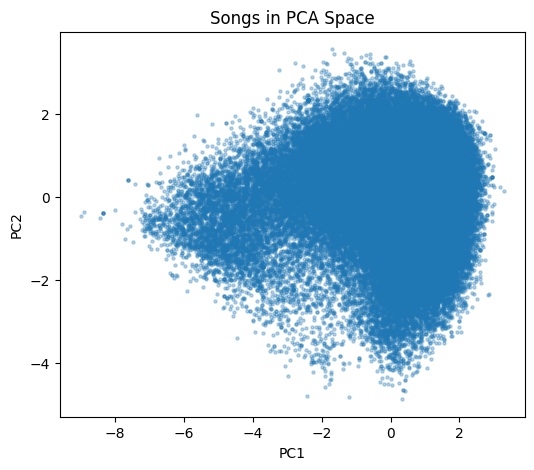

In [79]:


plt.figure(figsize=(6, 5))
plt.scatter(df["pc1"], df["pc2"], s=5, alpha=0.3)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Songs in PCA Space")
plt.show()


In [ ]:
#  Map PCs to "energetic" and "happy/sad" axes

# Compute correlations
corr_pc1_energy = np.corrcoef(df["pc1"], df["energy"])[0, 1]
corr_pc2_energy = np.corrcoef(df["pc2"], df["energy"])[0, 1]

corr_pc1_valence = np.corrcoef(df["pc1"], df["valence"])[0, 1]
corr_pc2_valence = np.corrcoef(df["pc2"], df["valence"])[0, 1]

print("corr(pc1, energy)  =", corr_pc1_energy)
print("corr(pc2, energy)  =", corr_pc2_energy)
print("corr(pc1, valence) =", corr_pc1_valence)
print("corr(pc2, valence) =", corr_pc2_valence)

# Decide which PC is more like "energy" (vertical axis) and which like "valence" (horizontal axis)
if abs(corr_pc1_energy) >= abs(corr_pc2_energy):
    energy_axis = "pc1"
    valence_axis = "pc2"
else:
    energy_axis = "pc2"
    valence_axis = "pc1"

print("Energy-like axis:", energy_axis)
print("Valence-like axis:", valence_axis)

# Create aligned mood coordinates
df["mood_energy_raw"] = df[energy_axis]
df["mood_valence_raw"] = df[valence_axis]

# Flip signs so that:
# - mood_energy increases with actual energy (up = more energetic)
# - mood_valence increases with actual valence (right = happier)
if np.corrcoef(df["mood_energy_raw"], df["energy"])[0, 1] < 0:
    df["mood_energy_raw"] = -df["mood_energy_raw"]

if np.corrcoef(df["mood_valence_raw"], df["valence"])[0, 1] < 0:
    df["mood_valence_raw"] = -df["mood_valence_raw"]

# (Optional) Scale them to roughly [-1, 1] for nicer geometry
# Here, we standardize then squash with tanh
from sklearn.preprocessing import StandardScaler

mood_scaler = StandardScaler()
mood_coords = mood_scaler.fit_transform(
    df[["mood_valence_raw", "mood_energy_raw"]].values
)

df["mood_x"] = np.tanh(mood_coords[:, 0])  # horizontal: Happy (+) / Sad (-)
df["mood_y"] = np.tanh(mood_coords[:, 1])  # vertical: Energetic (+) / Calm (-)

df[["pc1", "pc2", "mood_x", "mood_y"]].head()


corr(pc1, energy)  = 0.8582112828914792
corr(pc2, energy)  = -0.3458035898279236
corr(pc1, valence) = 0.5089142281547303
corr(pc2, valence) = 0.6302361219718385
Energy-like axis: pc1
Valence-like axis: pc2


,pc1,pc2,mood_x,mood_y
0,0.687034,1.049035,0.705316,0.383449
1,-3.189227,1.035571,0.699609,-0.954120
2,-1.315996,-0.216925,-0.179549,-0.649271
3,-3.189109,-0.499216,-0.395016,-0.954113
4,-0.886531,0.271094,0.223031,-0.478808


## Gaussian Mixture Method (GMM)

In [ ]:


X_mood = df[["mood_x", "mood_y"]].values

n_components = 8  # choose how many mood-ish clusters you want
gmm_mood = GaussianMixture(
    n_components=n_components,
    covariance_type="full",
    random_state=42
)

df["mood_cluster"] = gmm_mood.fit_predict(X_mood)

# Inspect cluster centers in mood space
cluster_centers = pd.DataFrame(
    gmm_mood.means_, columns=["mood_x_center", "mood_y_center"]
)
cluster_centers["cluster"] = np.arange(n_components)
cluster_centers


,mood_x_center,mood_y_center,cluster
0,0.094946,0.699813,0
1,-0.712133,-0.387584,1
2,0.559467,-0.863211,2
3,-0.892881,0.394688,3
4,0.800589,0.533113,4
5,0.603546,-0.013006,5
6,-0.344080,0.295650,6
7,-0.153409,-0.768045,7


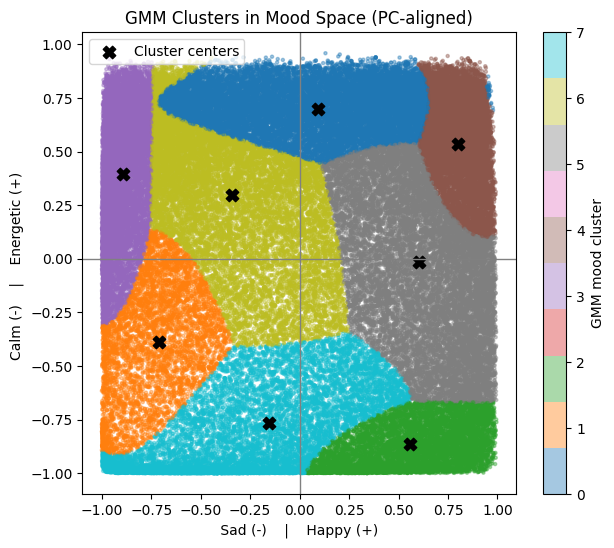

In [82]:
# Cell 4: Visualize mood clusters in the Happy–Sad / Energetic–Calm plane

import matplotlib.pyplot as plt

plt.figure(figsize=(7, 6))
scatter = plt.scatter(
    df["mood_x"], df["mood_y"],
    c=df["mood_cluster"], s=5, alpha=0.4, cmap="tab10"
)
plt.axhline(0, color="gray", linewidth=1)
plt.axvline(0, color="gray", linewidth=1)
plt.xlabel(" Sad (-)    |    Happy (+) ")
plt.ylabel("Calm (-)    |    Energetic (+) ")
plt.title("GMM Clusters in Mood Space (PC-aligned)")
plt.colorbar(scatter, label="GMM mood cluster")

# plot cluster centers
plt.scatter(
    cluster_centers["mood_x_center"],
    cluster_centers["mood_y_center"],
    c="black", s=80, marker="X", label="Cluster centers"
)
plt.legend()
plt.show()


## Assigning each cluster to the mood

In [83]:
# --- Cell: Map each GMM cluster to a mood label based on center coordinates ---

def mood_from_center(x, y):
    """
    x = mood_x_center  (happy (+)  → sad (-))
    y = mood_y_center  (energetic (+) → calm (-))
    """
    
    # Quadrant-based classification
    if x >= 0.3 and y >= 0.3:
        return "Exuberant / Happy-Energetic"
    if x >= 0.3 and y <= -0.3:
        return "Content / Calm-Happy"
    if x <= -0.3 and y >= 0.3:
        return "Anxious / Tense"
    if x <= -0.3 and y <= -0.3:
        return "Sad / Depressed / Melancholic"
    
    # Edge regions (intermediate moods)
    if x > 0.3:
        return "Warm / Romantic / Positive"
    if x < -0.3:
        return "Moody / Dark / Emotional"
    if y > 0.3:
        return "Energetic / Intense"
    if y < -0.3:
        return "Calm / Chill"

    # Center region (neutral)
    return "Neutral / Mixed mood"

# Apply the mapping
cluster_centers["mood_label"] = cluster_centers.apply(
    lambda row: mood_from_center(row["mood_x_center"], row["mood_y_center"]),
    axis=1
)

cluster_centers


,mood_x_center,mood_y_center,cluster,mood_label
0,0.094946,0.699813,0,Energetic / Intense
1,-0.712133,-0.387584,1,Sad / Depressed / Melancholic
2,0.559467,-0.863211,2,Content / Calm-Happy
3,-0.892881,0.394688,3,Anxious / Tense
4,0.800589,0.533113,4,Exuberant / Happy-Energetic
5,0.603546,-0.013006,5,Warm / Romantic / Positive
6,-0.344080,0.295650,6,Moody / Dark / Emotional
7,-0.153409,-0.768045,7,Calm / Chill


In [84]:
# --- Cell: Add cluster mood labels to your dataframe ---

df = df.merge(cluster_centers[["cluster", "mood_label"]],
              left_on="mood_cluster",
              right_on="cluster",
              how="left")

df.head()


,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,track_genre,pc1,pc2,mood_energy_raw,mood_valence_raw,mood_x,mood_y,mood_cluster,cluster,mood_label
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,acoustic,0.687034,1.049035,0.687034,1.049035,0.705316,0.383449,4,4,Exuberant / Happy-Energetic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,acoustic,-3.189227,1.035571,-3.189227,1.035571,0.699609,-0.954120,2,2,Content / Calm-Happy
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,acoustic,-1.315996,-0.216925,-1.315996,-0.216925,-0.179549,-0.649271,7,7,Calm / Chill
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,acoustic,-3.189109,-0.499216,-3.189109,-0.499216,-0.395016,-0.954113,7,7,Calm / Chill
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,acoustic,-0.886531,0.271094,-0.886531,0.271094,0.223031,-0.478808,7,7,Calm / Chill


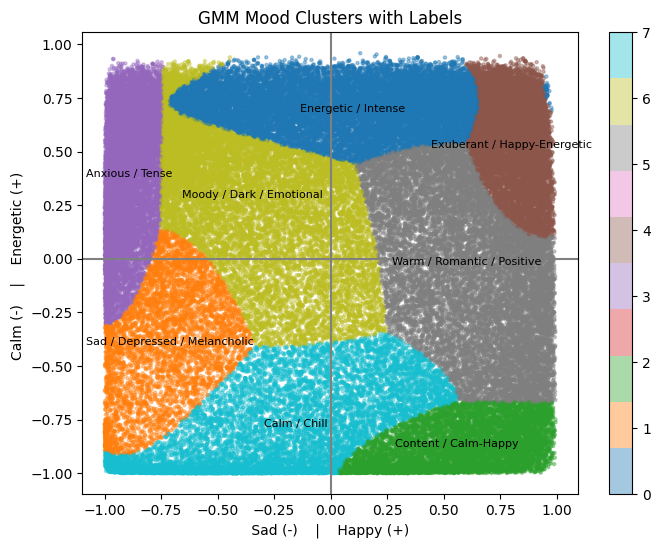

In [85]:
plt.figure(figsize=(8,6))
scatter = plt.scatter(df["mood_x"], df["mood_y"],
                      c=df["mood_cluster"], s=5, alpha=0.4, cmap="tab10")

# Add center labels
for _, row in cluster_centers.iterrows():
    plt.text(row["mood_x_center"], row["mood_y_center"],
             row["mood_label"],
             fontsize=8, ha='center', va='center')

plt.axhline(0, color='gray')
plt.axvline(0, color='gray')
plt.xlabel(" Sad (-)    |    Happy (+) ")
plt.ylabel("Calm (-)    |    Energetic (+) ")
plt.title("GMM Mood Clusters with Labels")
plt.colorbar(scatter)
plt.show()


## Recommendation system

In [86]:
import numpy as np
import pandas as pd

def recommend_songs_mood_space(
    df,
    target_mood,          # tuple (x, y)
    genres=None,          # list of preferred genres or None
    min_popularity=0,
    max_popularity=100,
    neighborhood_size=300,
    n_random=10,
    random_state=None
):
    tx, ty = target_mood

    # Start
    songs = df.copy()

    # Filter by popularity
    songs = songs[
        (songs["popularity"] >= min_popularity) &
        (songs["popularity"] <= max_popularity)
    ]

    # Filter by genres
    if genres is not None:
        genres_lower = [g.lower() for g in genres]
        songs = songs[songs["track_genre"].str.lower().isin(genres_lower)]

    if songs.empty:
        print("No songs found after filtering. Try different genre/popularity settings.")
        return songs

    # Compute distance in mood space
    dx = songs["mood_x"] - tx
    dy = songs["mood_y"] - ty
    songs["mood_distance"] = np.sqrt(dx**2 + dy**2)

    # Take nearest neighborhood_size
    songs = songs.sort_values("mood_distance").head(neighborhood_size)

    # Random sample of n_random songs
    n_random = min(n_random, len(songs))
    songs = songs.sample(n=n_random, random_state=random_state)

    return songs[
        ["track_name", "artists", "track_genre",
         "popularity", "mood_x", "mood_y", "mood_distance"]
    ].reset_index(drop=True)


In [114]:
target = (0.8, 0.6)  # very happy + energetic

recs = recommend_songs_mood_space(
    df,
    target_mood=target,
    genres=["pop", "dance pop"],
    min_popularity=50,
    max_popularity=100,
    neighborhood_size=50,
    n_random=10
)

recs


,track_name,artists,track_genre,popularity,mood_x,mood_y,mood_distance
0,Mood (feat. iann dior),24kGoldn;iann dior,pop,83,0.658305,0.637004,0.146447
1,Shape of You,Ed Sheeran,pop,86,0.966057,0.553854,0.172349
2,"Coka 2.0 (From ""Liger"")",Jaani;Lijo George-Dj Chetas;Sukh-E Muzical Doc...,pop,66,0.812831,0.776957,0.177421
3,"Coka 2.0 (From ""Liger (Telugu)"")",Jaani;Lijo George-Dj Chetas;Ram Miriyala;Geeth...,pop,66,0.901223,0.735659,0.169261
4,Savage Love (Laxed – Siren Beat) [BTS Remix],Jawsh 685;Jason Derulo;BTS,pop,73,0.518100,0.640483,0.284792
5,Baby,Justin Bieber;Ludacris,pop,82,0.621856,0.613577,0.178660
6,"Ghalat Fehmi - From ""Superstar""",Asim Azhar;Zenab Fatimah Sultan,pop,66,0.887002,0.286563,0.325287
7,"Naah Goriye (From ""Bala"")",B Praak;Harrdy Sandhu;Swasti Mehul,pop,64,0.894753,0.653542,0.108835
8,"Aafat (From ""Liger"")",Tanishk Bagchi;Rashmi Virag;Zahrah S Khan,pop,66,0.575377,0.733787,0.261447
9,Raanjhana Ve,Soham Naik;Antara Mitra;Uddipan Sharma,pop,64,0.802643,0.406605,0.193413


In [104]:
count_pop_80_100 = df[(df["popularity"] >= 80) & (df["popularity"] <= 100)].shape[0]
count_pop_80_100


627

## Compairing different k's for GMM

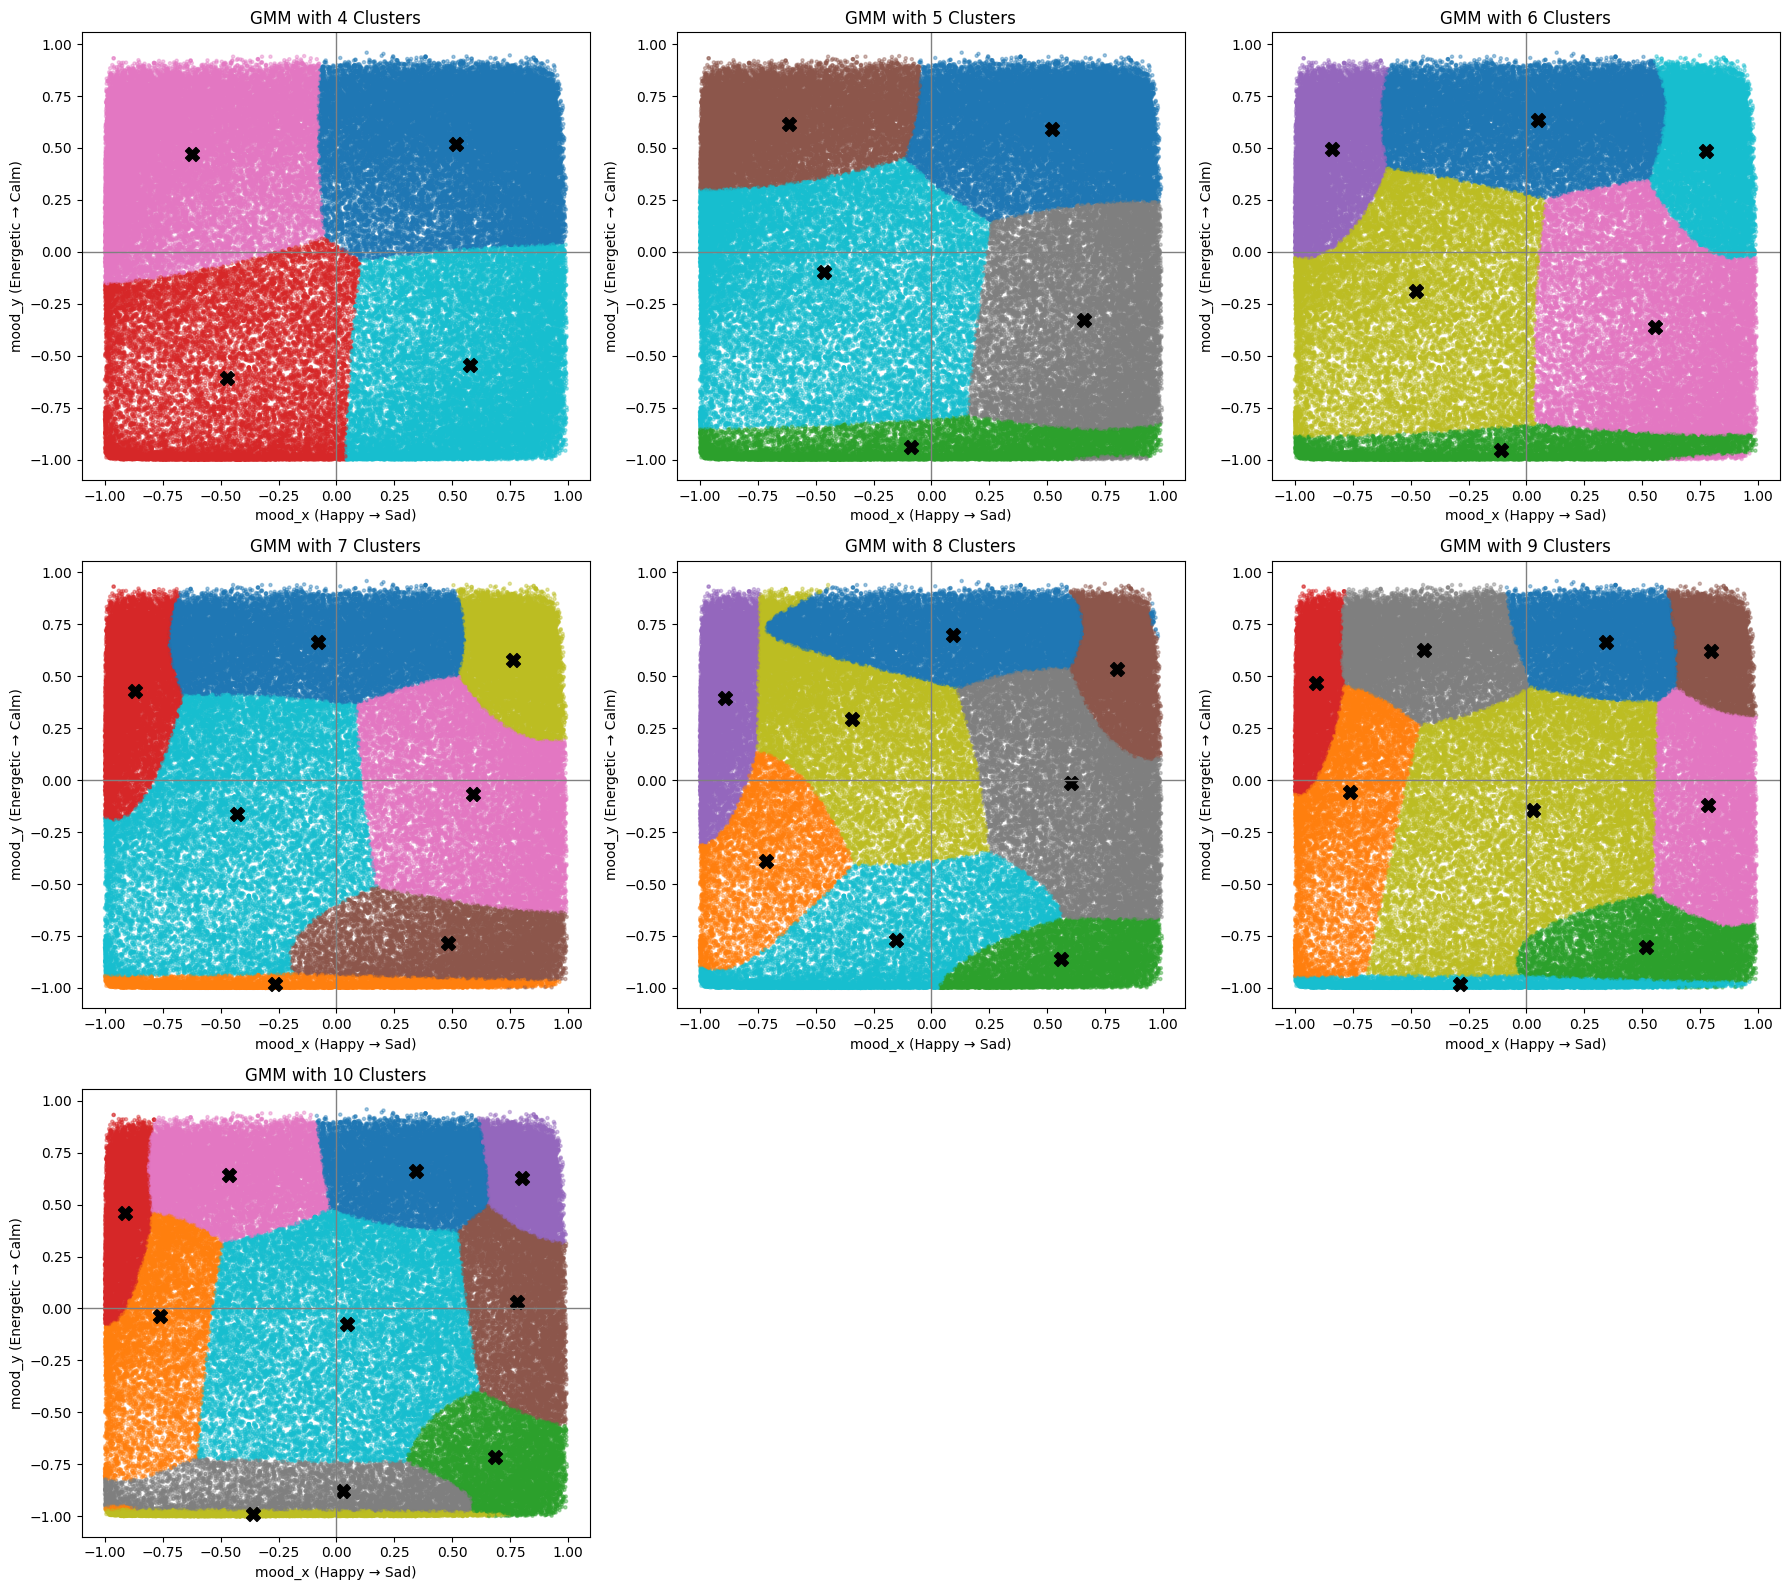

In [106]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# X_mood is your (mood_x, mood_y) matrix:
# Make sure you defined earlier:
# X_mood = df[["mood_x", "mood_y"]].values

plt.figure(figsize=(18, 16))

plot_index = 1

for k in range(4, 11):   # 4 to 10 clusters
    gmm_temp = GaussianMixture(
        n_components=k,
        covariance_type="full",
        random_state=42
    )
    
    cluster_labels = gmm_temp.fit_predict(X_mood)
    centers = gmm_temp.means_
    
    # ----- Plot -----
    plt.subplot(3, 3, plot_index)
    plt.scatter(
        df["mood_x"], df["mood_y"],
        c=cluster_labels,
        s=5,
        cmap="tab10",
        alpha=0.4
    )
    
    # plot centers
    plt.scatter(
        centers[:, 0], centers[:, 1],
        c="black", s=100, marker="X"
    )

    plt.title(f"GMM with {k} Clusters")
    plt.axhline(0, color='gray', linewidth=1)
    plt.axvline(0, color='gray', linewidth=1)
    plt.xlabel("mood_x (Happy → Sad)")
    plt.ylabel("mood_y (Energetic → Calm)")
    
    plot_index += 1

plt.tight_layout()
plt.show()


## Finding the location of the music in the mood space

In [107]:
import matplotlib.pyplot as plt

def show_song_in_mood_space(df, song_name, case_insensitive=True):
    """
    Find song(s) by name and plot their position in the mood space.
    song_name: full or partial track name.
    """

    # --- find matches ---
    if case_insensitive:
        mask = df["track_name"].str.contains(song_name, case=False, na=False)
    else:
        mask = df["track_name"].str.contains(song_name, na=False)

    matches = df[mask]

    if matches.empty:
        print(f"No songs found matching: {song_name!r}")
        return

    print("Found songs:")
    display_cols = ["track_name", "artists", "track_genre",
                    "popularity", "mood_x", "mood_y"]
    print(matches[display_cols])

    # --- plot in mood space ---
    plt.figure(figsize=(6,5))
    # all songs faint in background
    plt.scatter(df["mood_x"], df["mood_y"], s=3, alpha=0.15, color="gray")

    # matched songs highlighted
    plt.scatter(matches["mood_x"], matches["mood_y"],
                s=80, color="red", marker="X", label="Selected song(s)")

    for _, row in matches.iterrows():
        plt.text(row["mood_x"] + 0.02, row["mood_y"] + 0.02,
                 row["track_name"][:20], fontsize=8)

    plt.axhline(0, color="black", linewidth=0.7)
    plt.axvline(0, color="black", linewidth=0.7)
    plt.xlabel("Happy (+)  ←→  Sad (-)")
    plt.ylabel("Energetic (+)  ←→  Calm (-)")
    plt.title("Song position in mood space")
    plt.legend()
    plt.show()


Found songs:
                     track_name        artists track_genre  popularity  \
14184         Happier Than Ever           ASTN       chill          76   
28436  Happier Than Ever - Edit  Billie Eilish     electro          82   
66371         Happier Than Ever         Philip       piano          42   
67904         Happier Than Ever  Billie Eilish         pop           0   
68014         Happier Than Ever  Billie Eilish         pop          88   
71140         happier than ever       Loveless        punk          65   

         mood_x    mood_y  
14184  0.529495 -0.023921  
28436 -0.912302  0.121485  
66371 -0.001841 -0.994336  
67904  0.311006 -0.852505  
68014  0.317551 -0.848757  
71140 -0.948325  0.510444  


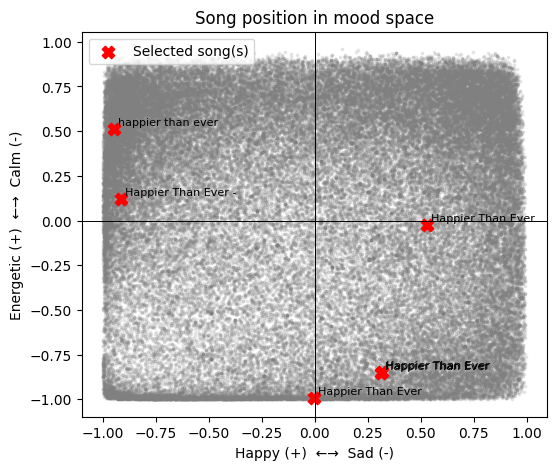

In [108]:
show_song_in_mood_space(df, "Happier Than Ever")


In [109]:
import matplotlib.pyplot as plt

def show_song_in_mood_space_by_name_artist(df, song_name, artist_name,
                                           case_insensitive=True):
    """
    Locate and visualize songs by BOTH track_name AND artist.
    Supports partial matches.
    """

    # --- Build search conditions ---
    if case_insensitive:
        name_mask   = df["track_name"].str.contains(song_name,  case=False, na=False)
        artist_mask = df["artists"].str.contains(artist_name, case=False, na=False)
    else:
        name_mask   = df["track_name"].str.contains(song_name,  na=False)
        artist_mask = df["artists"].str.contains(artist_name, na=False)

    matches = df[name_mask & artist_mask]

    # --- Check matches ---
    if matches.empty:
        print(f"No songs found matching: Name='{song_name}' AND Artist='{artist_name}'")
        return

    print("Found matching song(s):")
    display_cols = ["track_name", "artists", "track_genre",
                    "popularity", "mood_x", "mood_y"]
    print(matches[display_cols])

    # --- Plot ---
    plt.figure(figsize=(6,5))

    # Scatter all songs faintly
    plt.scatter(df["mood_x"], df["mood_y"], s=3, alpha=0.15, color="gray")

    # Highlight matches
    plt.scatter(matches["mood_x"], matches["mood_y"],
                s=100, color="red", marker="X", label="Selected Song(s)")

    # Add labels near each match
    for _, row in matches.iterrows():
        plt.text(row["mood_x"] + 0.02, row["mood_y"] + 0.02,
                 row["track_name"][:25], fontsize=8, weight="bold")

    plt.axhline(0, color="black", linewidth=0.7)
    plt.axvline(0, color="black", linewidth=0.7)

    plt.xlabel("Happy (+)  ←→  Sad (-)")
    plt.ylabel("Energetic (+)  ←→  Calm (-)")
    plt.title("Song Location in Mood Space")
    plt.legend()
    plt.show()


Found matching song(s):
                 track_name       artists track_genre  popularity    mood_x  \
68018  Say You Won't Let Go  James Arthur         pop          85  0.345705   

       mood_y  
68018 -0.5107  


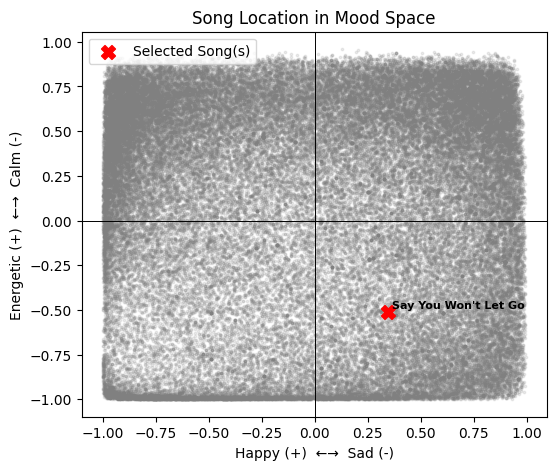

In [111]:
show_song_in_mood_space_by_name_artist(df, "Say You Won't Let Go", "James Arthur") 


# Testing part
## 1. Clustering Testing
1.1 GMM metrics: log-likelihood, BIC, AIC, silhouette

In [115]:
from sklearn.metrics import silhouette_score

def evaluate_gmm_clusters(X_mood, gmm, labels):
    """
    Evaluate how good the GMM clustering is, using:
    - average log-likelihood
    - BIC, AIC
    - silhouette score in the mood space
    """
    # Average log-likelihood per point
    avg_log_likelihood = gmm.score(X_mood)  # already average per sample

    # Model selection criteria
    bic = gmm.bic(X_mood)
    aic = gmm.aic(X_mood)

    # Silhouette (how well-separated clusters are in mood space)
    try:
        sil = silhouette_score(X_mood, labels)
    except Exception as e:
        sil = None
        print("Could not compute silhouette_score:", e)

    print("==== GMM Evaluation ====")
    print(f"Number of components: {gmm.n_components}")
    print(f"Average log-likelihood: {avg_log_likelihood:.4f}")
    print(f"BIC: {bic:.2f}")
    print(f"AIC: {aic:.2f}")
    if sil is not None:
        print(f"Silhouette score: {sil:.4f}")
    print("========================")

# usage
evaluate_gmm_clusters(X_mood, gmm, df["mood_cluster"].values)


==== GMM Evaluation ====
Number of components: 8
Average log-likelihood: -2.8251
BIC: 507584.42
AIC: 507142.40
Silhouette score: 0.2492


1.2 Intra-cluster vs inter-cluster distances

In [116]:
import numpy as np

def intra_inter_cluster_distance(df, X_mood, label_col="mood_cluster", n_samples=5000, random_state=42):
    np.random.seed(random_state)
    idx = np.random.choice(len(df), size=min(n_samples, len(df)), replace=False)
    
    X_sub = X_mood[idx]
    labels_sub = df[label_col].values[idx]
    
    intra_dists = []
    inter_dists = []
    
    for i in range(len(idx)):
        for j in range(i+1, len(idx)):
            d = np.linalg.norm(X_sub[i] - X_sub[j])
            if labels_sub[i] == labels_sub[j]:
                intra_dists.append(d)
            else:
                inter_dists.append(d)
    
    intra_dists = np.array(intra_dists)
    inter_dists = np.array(inter_dists)
    
    print("Mean intra-cluster distance: ", intra_dists.mean())
    print("Mean inter-cluster distance:", inter_dists.mean())
    print("Ratio inter / intra:", inter_dists.mean() / intra_dists.mean())
    
    return intra_dists, inter_dists

intra_d, inter_d = intra_inter_cluster_distance(df, X_mood)


Mean intra-cluster distance:  0.4426204815450841
Mean inter-cluster distance: 1.2122584935757386
Ratio inter / intra: 2.73882150537641


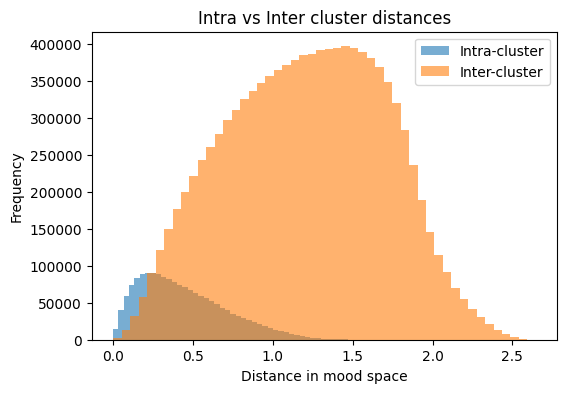

In [117]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(intra_d, bins=50, alpha=0.6, label="Intra-cluster")
plt.hist(inter_d, bins=50, alpha=0.6, label="Inter-cluster")
plt.xlabel("Distance in mood space")
plt.ylabel("Frequency")
plt.legend()
plt.title("Intra vs Inter cluster distances")
plt.show()


## 2. Testing the recommendation system
2.1. Function: evaluate recommendations vs random

In [121]:
def evaluate_recommender(df, target_mood,
                         genres=None,
                         min_popularity=0, max_popularity=100,
                         n_test=100, n_recs=10, random_state=42):
    """
    Test how well recommendations match target mood compared to random songs.
    Uses only mood-space distance.
    """
    np.random.seed(random_state)
    tx, ty = target_mood
    
    # Filter pool
    pool = df[
        (df["popularity"] >= min_popularity) &
        (df["popularity"] <= max_popularity)
    ].copy()
    if genres is not None:
        genres_lower = [g.lower() for g in genres]
        pool = pool[pool["track_genre"].str.lower().isin(genres_lower)]
    
    if len(pool) < n_recs:
        print("Not enough songs in pool to test.")
        return
    
    rec_dists = []
    rand_dists = []
    
    for _ in range(n_test):
        # recommendations from your system
        recs = recommend_songs_mood_space(
            pool,
            target_mood=target_mood,
            genres=None,  # already filtered
            min_popularity=min_popularity,
            max_popularity=max_popularity,
            neighborhood_size=300,
            n_random=n_recs,
            random_state=None
        )
        
        # random songs from same pool
        rand = pool.sample(n=n_recs)
        
        # compute distances in mood space
        rec_dist = np.sqrt((recs["mood_x"] - tx)**2 + (recs["mood_y"] - ty)**2)
        rand_dist = np.sqrt((rand["mood_x"] - tx)**2 + (rand["mood_y"] - ty)**2)
        
        rec_dists.extend(rec_dist.values)
        rand_dists.extend(rand_dist.values)
    
    rec_dists = np.array(rec_dists)
    rand_dists = np.array(rand_dists)
    
    print("=== Recommender vs Random (mood distance) ===")
    print(f"Mean distance (recs):   {rec_dists.mean():.4f}")
    print(f"Mean distance (random): {rand_dists.mean():.4f}")
    print(f"Ratio random / recs:    {rand_dists.mean() / rec_dists.mean():.2f}")
    
    return rec_dists, rand_dists


In [122]:
target_mood = (0.8, 0.4)  # happy + energetic corner, for example

rec_d, rnd_d = evaluate_recommender(
    df,
    target_mood=target_mood,
    genres=["pop"],
    min_popularity=40,
    max_popularity=100,
    n_test=50,
    n_recs=10
)


=== Recommender vs Random (mood distance) ===
Mean distance (recs):   0.8554
Mean distance (random): 0.8713
Ratio random / recs:    1.02
